In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import SimpleITK as sitk
import pydicom

from tqdm import tqdm
from torch import nn,optim
import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [2]:
images = sorted(os.listdir("/kaggle/input/segmentation-new/Segmentation_MRCNN/Pancreas_slice"))
masks = sorted(os.listdir("/kaggle/input/segmentation-new/Segmentation_MRCNN/Mask"))

In [3]:
images[0]

'pancreas_001.dcm'

In [4]:
idx = 0
img = pydicom.dcmread("/kaggle/input/segmentation-new/Segmentation_MRCNN/Pancreas_slice/" + images[idx]).pixel_array
mask = pydicom.dcmread("/kaggle/input/segmentation-new/Segmentation_MRCNN/Mask/" + masks[idx]).pixel_array

In [5]:
img

array([[-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       ...,
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024]], dtype=int16)

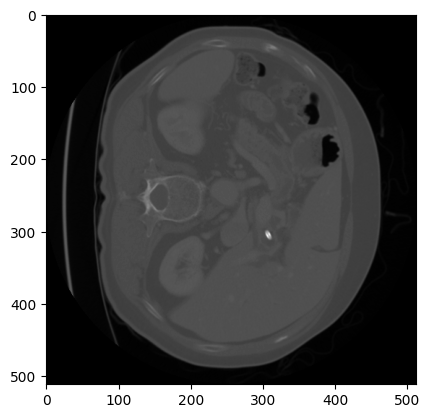

In [6]:
plt.imshow(img,cmap="gray")

In [7]:
mask = mask.astype(np.float32)


In [8]:
np.unique(mask)


array([0., 1., 2.], dtype=float32)

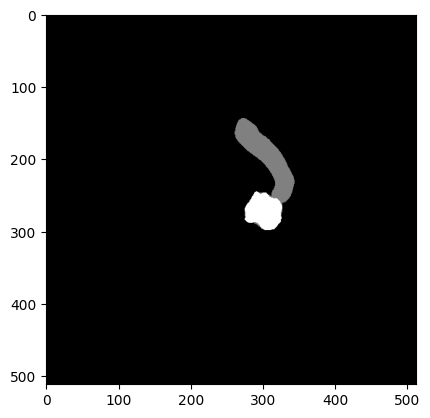

In [9]:
plt.imshow(mask,cmap="gray")

In [10]:
# Image.fromarray(np.array(mask) == 2)


In [11]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self , images , masks):
        self.imgs = images
        self.masks = masks
        
    def __getitem__(self , idx):
        img = pydicom.dcmread("/kaggle/input/segmentation-new/Segmentation_MRCNN/Pancreas_slice/" + self.imgs[idx]).pixel_array
        mask = pydicom.dcmread("/kaggle/input/segmentation-new/Segmentation_MRCNN/Mask/" + self.masks[idx]).pixel_array
        
        # Convert the int16 array to float32 (to prevent overflow during normalization)
        image_array_float32 = img.astype(np.float32)

        # Normalize the image array to the range [0, 1]
        image_array_normalized = (image_array_float32 - np.min(image_array_float32)) / (np.max(image_array_float32) - np.min(image_array_float32))

        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)
        masks = np.zeros((num_objs , mask.shape[0] , mask.shape[1]))
        for i in range(num_objs):
            masks[i][mask == i+1] = True
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin , ymin , xmax , ymax])
        boxes = torch.as_tensor(boxes , dtype = torch.float32)
        labels = torch.ones((num_objs,) , dtype = torch.int64)
        masks = torch.as_tensor(masks , dtype = torch.uint8)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        return T.ToTensor()(image_array_normalized) , target
    
    def __len__(self):
        return len(self.imgs)

In [12]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s] 


In [14]:
# # Freeze all layers except box_predictor and mask_predictor
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the parameters of the box_predictor and mask_predictor
# for param in model.roi_heads.box_predictor.parameters():
#     param.requires_grad = True

# for param in model.roi_heads.mask_predictor.parameters():
#     param.requires_grad = True

In [13]:
transform = T.ToTensor()


In [14]:
def custom_collate(data):
  return data

In [15]:
images = sorted(os.listdir("/kaggle/input/segmentation-new/Segmentation_MRCNN/Pancreas_slice"))
masks = sorted(os.listdir("/kaggle/input/segmentation-new/Segmentation_MRCNN/Mask"))
num = int(0.8 * len(images))
num = num if num % 2 == 0 else num + 1
train_imgs_inds = np.random.choice(range(len(images)) , num , replace = False)
val_imgs_inds = np.setdiff1d(range(len(images)) , train_imgs_inds)
train_imgs = np.array(images)[train_imgs_inds]
val_imgs = np.array(images)[val_imgs_inds]
train_masks = np.array(masks)[train_imgs_inds]
val_masks = np.array(masks)[val_imgs_inds]

In [16]:
# train_masks

In [17]:
train_dl = torch.utils.data.DataLoader(CustDat(train_imgs , train_masks) , 
                                 batch_size = 2 , 
                                 shuffle = True , 
                                 collate_fn = custom_collate , 
                                 num_workers = 1 , 
                                 pin_memory = True if torch.cuda.is_available() else False)
val_dl = torch.utils.data.DataLoader(CustDat(val_imgs , val_masks) , 
                                 batch_size = 2 , 
                                 shuffle = True , 
                                 collate_fn = custom_collate , 
                                 num_workers = 1 , 
                                 pin_memory = True if torch.cuda.is_available() else False)

In [18]:
# Check if GPU is available and if not, fall back on CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Computing device is: ", device)
num_gpus = torch.cuda.device_count()

all_gpu_ids = list(range(torch.cuda.device_count()))
print(all_gpu_ids)

Computing device is:  cuda
[0, 1]


In [19]:
# Copying the model onto multiple GPUs
model.to(device)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [109]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)


In [110]:
all_train_losses = []
all_val_losses = []
flag = False
for epoch in range(42):
    train_epoch_loss = 0
    val_epoch_loss = 0
    model.train()
    progress_bar = tqdm(enumerate(train_dl), total=len(train_dl), desc=f"Epoch {epoch+1}")

    for i , dt in progress_bar:
        imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
        targ = [dt[0][1] , dt[1][1]]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
        loss = model(imgs , targets)
        if not flag:
            print(loss)
            flag = True
        losses = sum([l for l in loss.values()])
        train_epoch_loss += losses.cpu().detach().numpy()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    all_train_losses.append(train_epoch_loss)
    with torch.no_grad():
        progress_bar = tqdm(enumerate(val_dl), total=len(val_dl), desc=f"Epoch {epoch+1}")

        for j , dt in progress_bar:
            imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
            targ = [dt[0][1] , dt[1][1]]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            loss = model(imgs , targets)
            losses = sum([l for l in loss.values()])
            val_epoch_loss += losses.cpu().detach().numpy()
        all_val_losses.append(val_epoch_loss)
    print(epoch , "  " , train_epoch_loss , "  " , val_epoch_loss)

Epoch 1:   0%|          | 2/576 [00:00<02:11,  4.38it/s]

{'loss_classifier': tensor(0.7489, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(2.1866, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.6925, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0145, device='cuda:0')}


Epoch 1: 100%|██████████| 144/144 [00:24<00:00,  5.81it/s]

0    868.212503194809    190.0840871334076



Epoch 2: 100%|██████████| 144/144 [00:24<00:00,  5.84it/s]


1    747.7182394266129    185.60071682929993


Epoch 3: 100%|██████████| 144/144 [00:24<00:00,  5.83it/s]


2    735.9291024208069    183.11199009418488


Epoch 4: 100%|██████████| 144/144 [00:24<00:00,  5.84it/s]


3    726.0394438505173    183.4339028596878


Epoch 5: 100%|██████████| 144/144 [00:24<00:00,  5.84it/s]


4    724.0938078165054    180.68514144420624


Epoch 6: 100%|██████████| 144/144 [00:24<00:00,  5.85it/s]

5    719.5352100133896    180.54399073123932



Epoch 7: 100%|██████████| 144/144 [00:24<00:00,  5.84it/s]

6    716.7711392641068    180.29018080234528



Epoch 8: 100%|██████████| 144/144 [00:24<00:00,  5.85it/s]

7    715.4265677928925    180.5954909324646



Epoch 9: 100%|██████████| 144/144 [00:24<00:00,  5.84it/s]

8    711.4612492322922    181.6882040500641



Epoch 10: 100%|██████████| 144/144 [00:24<00:00,  5.84it/s]


9    710.8771116733551    179.5675538778305


Epoch 11: 100%|██████████| 144/144 [00:24<00:00,  5.86it/s]


10    707.0665783882141    179.09137892723083


Epoch 12: 100%|██████████| 144/144 [00:24<00:00,  5.84it/s]

11    706.4725986719131    180.12912833690643



Epoch 13: 100%|██████████| 144/144 [00:24<00:00,  5.85it/s]


12    705.8328224420547    178.7092957496643


Epoch 14: 100%|██████████| 144/144 [00:24<00:00,  5.84it/s]

13    704.4082462787628    178.0560930967331



Epoch 15: 100%|██████████| 144/144 [00:24<00:00,  5.84it/s]

14    702.1620439291    177.57728683948517



Epoch 16: 100%|██████████| 144/144 [00:24<00:00,  5.85it/s]


15    699.5873548984528    177.96876668930054


Epoch 17: 100%|██████████| 144/144 [00:24<00:00,  5.83it/s]


16    700.3277453184128    177.24884867668152


Epoch 18: 100%|██████████| 144/144 [00:24<00:00,  5.83it/s]


17    697.5128793716431    178.18844854831696


Epoch 19: 100%|██████████| 144/144 [00:24<00:00,  5.86it/s]


18    698.1627231836319    177.24977469444275


Epoch 20: 100%|██████████| 144/144 [00:24<00:00,  5.85it/s]


19    697.7556380033493    179.78050684928894


Epoch 21: 100%|██████████| 144/144 [00:24<00:00,  5.85it/s]


20    697.1482722759247    178.159827709198


Epoch 22: 100%|██████████| 144/144 [00:24<00:00,  5.83it/s]


21    695.709224820137    177.1334766149521


Epoch 23: 100%|██████████| 144/144 [00:24<00:00,  5.83it/s]

22    692.9859220981598    176.61487364768982



Epoch 24: 100%|██████████| 144/144 [00:24<00:00,  5.85it/s]


23    694.5736584663391    177.27131187915802


Epoch 25: 100%|██████████| 144/144 [00:24<00:00,  5.84it/s]

24    694.2223358154297    177.11714255809784



Epoch 26: 100%|██████████| 144/144 [00:24<00:00,  5.86it/s]

25    692.0238476991653    176.31964933872223



Epoch 27: 100%|██████████| 144/144 [00:24<00:00,  5.86it/s]

26    694.2567360401154    176.54713141918182



Epoch 28: 100%|██████████| 144/144 [00:24<00:00,  5.86it/s]

27    692.1487129926682    176.7404224872589



Epoch 29: 100%|██████████| 144/144 [00:24<00:00,  5.86it/s]


28    692.1919709444046    178.49547410011292


Epoch 30: 100%|██████████| 144/144 [00:24<00:00,  5.87it/s]

29    692.0326153039932    176.8649125099182



Epoch 31: 100%|██████████| 144/144 [00:24<00:00,  5.86it/s]


30    691.2173247337341    176.92615818977356


Epoch 32: 100%|██████████| 144/144 [00:24<00:00,  5.87it/s]


31    690.2283139228821    176.65123808383942


Epoch 33: 100%|██████████| 144/144 [00:24<00:00,  5.86it/s]

32    688.8575547933578    176.44281613826752



Epoch 34: 100%|██████████| 144/144 [00:24<00:00,  5.87it/s]

33    688.2868028879166    177.5456259250641



Epoch 35: 100%|██████████| 144/144 [00:24<00:00,  5.86it/s]


34    689.3691247701645    176.07877922058105


Epoch 36: 100%|██████████| 144/144 [00:24<00:00,  5.88it/s]

35    688.4222952127457    177.07287085056305



Epoch 37: 100%|██████████| 144/144 [00:24<00:00,  5.86it/s]


36    688.3633494377136    176.57565796375275


Epoch 38: 100%|██████████| 144/144 [00:24<00:00,  5.87it/s]

37    687.7079809904099    176.66858434677124



Epoch 39: 100%|██████████| 144/144 [00:24<00:00,  5.86it/s]


38    690.23730635643    176.40060901641846


Epoch 40: 100%|██████████| 144/144 [00:24<00:00,  5.85it/s]

39    687.5404732227325    176.01157367229462



Epoch 41: 100%|██████████| 144/144 [00:24<00:00,  5.87it/s]


40    688.6051309108734    176.697052359581


Epoch 42: 100%|██████████| 144/144 [00:24<00:00,  5.87it/s]

41    686.6628049612045    176.9870561361313


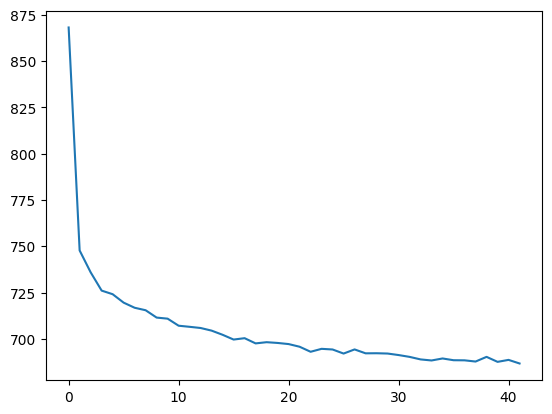

In [124]:
plt.plot(all_train_losses)


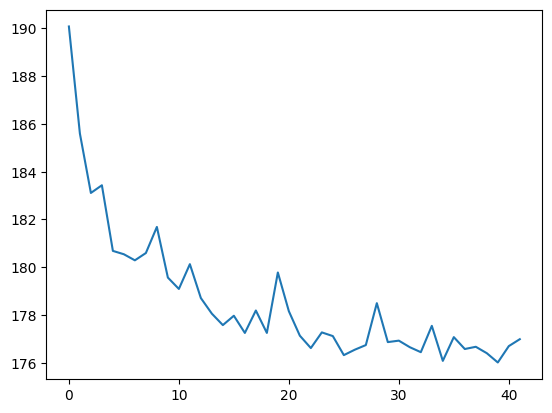

In [125]:
plt.plot(all_val_losses)


In [360]:
images = sorted(os.listdir("/kaggle/input/segmentation-new/Segmentation_MRCNN/Pancreas_slice"))
masks = sorted(os.listdir("/kaggle/input/segmentation-new/Segmentation_MRCNN/Mask"))
idx = 1263
img = pydicom.dcmread("/kaggle/input/segmentation-new/Segmentation_MRCNN/Pancreas_slice/" + images[idx]).pixel_array
mask = pydicom.dcmread("/kaggle/input/segmentation-new/Segmentation_MRCNN/Mask/" + masks[idx]).pixel_array

In [362]:
# Load the pre-trained weights
weights_path = "/kaggle/input/mrcnn-weights/model_weights.pth"
model.load_state_dict(torch.load(weights_path))
model.eval()
transform = T.ToTensor()
# Convert the int16 array to float32 (to prevent overflow during normalization)
image_array_float32 = img.astype(np.float32)

# Normalize the image array to the range [0, 1]
image_array_normalized = (image_array_float32 - np.min(image_array_float32)) / (np.max(image_array_float32) - np.min(image_array_float32))

ig = transform(image_array_normalized)
with torch.no_grad():
    pred = model([ig.to(device)])

In [377]:
import torch

def dice_coefficient(predicted, target, epsilon=1e-7):
    intersection = torch.nonzero(predicted.float() * target.float())
    print(len(intersection))
#     print(predicted.shape)
#     print(target.shape)
    union = len(torch.nonzero(predicted)) + len(torch.nonzero(target))
#     print(len(union))
    dice_score = (2. * len(intersection) + epsilon) / (union + epsilon)
    return dice_score

# # Example usage:
# predicted_mask = torch.tensor([[1, 0, 1],
#                                [0, 1, 0],
#                                [1, 0, 1]], dtype=torch.float32)
# target_mask = torch.tensor([[1, 1, 0],
#                             [1, 1, 0],
#                             [0, 0, 0]], dtype=torch.float32)
k3 = k3.astype(np.float32)
mask = mask.astype(np.float32)



dice = dice_coefficient(torch.tensor(k3[0]), torch.tensor(mask))
print("Dice Coefficient:", dice)


3069
Dice Coefficient: 0.8122270742382927


In [20]:
import os

# Specify the folder name
tumor_slice = "Tumor_slice"
tumor_mask_slice = "Tumor_Mask_slice"
Pancreas_slice = "Pancreas_slice"
Pancreas_mask_slice = "Pancreas_Mask_slice"


# Create the folder
os.makedirs(tumor_slice, exist_ok=True)
os.makedirs(tumor_mask_slice, exist_ok=True)
os.makedirs(Pancreas_slice, exist_ok=True)
os.makedirs(Pancreas_mask_slice, exist_ok=True)

In [21]:
def convertNsave(arr,path,category):
    
    
    dicom_file = pydicom.dcmread('/kaggle/input/segmentation-new/Segmentation_MRCNN/Pancreas_slice/pancreas_001.dcm')
    arr = arr.astype('int16')
    dicom_file.Rows = arr.shape[0]
    dicom_file.Columns = arr.shape[1]
    dicom_file.PhotometricInterpretation = "MONOCHROME2"
    dicom_file.SamplesPerPixel = 1
    dicom_file.BitsStored = 16
    dicom_file.BitsAllocated = 16
    dicom_file.HighBit = 15

    if category==0:
        dicom_file.PixelRepresentation = 1
        dicom_file.PixelData = arr.tobytes()
        dicom_file.save_as(path)

    else: 
        dicom_file.PixelRepresentation = 0
        dicom_file.PixelData = arr.tobytes()
        dicom_file.save_as(path)

In [22]:

weights_path = "/kaggle/input/mrcnn-weights/model_weights.pth"
path_tumor = "/kaggle/working/Tumor_slice/"
path_tumor_mask = "/kaggle/working/Tumor_Mask_slice/"
path_pancreas = "/kaggle/working/Pancreas_slice/"
path_pancreas_mask = "/kaggle/working/Pancreas_Mask_slice/"
model.load_state_dict(torch.load(weights_path))
# Ensure the model is in evaluation mode
model.eval()
epoch = 2
with torch.no_grad():
    progress_bar = tqdm(enumerate(train_dl), total=len(train_dl), desc=f"Epoch {epoch+1}")
    
    total_dice = 0
    total_iou = 0
    total_accuracy = 0
    total_precision = 0
    total_recall = 0
    count_tumor = 0
    count_pancreas = 0
    for j, dt in progress_bar:
        imgs = [dt[0][0].to(device), dt[1][0].to(device)]
        targ = [dt[0][1], dt[1][1]]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
        
        
        # Perform inference
        predictions = model(imgs)
#         print(len(predictions))
#         break
        # Compute metrics
        for i in range(len(predictions)):
            pred_mask = predictions[i]  # Predicted segmentation mask
            true_mask = targ[i]['masks'].cpu().numpy()  # Ground truth segmentation mask
            true_mask = torch.tensor(true_mask)
#             binary_true_mask = true_mask
            
#             binary_true_mask[binary_true_mask>0]=1
#             print(pred_mask['masks'].shape)
            if(len(pred_mask['masks']) > 1):
                threshold = 0.48  # Set your threshold here
                k1 = pred_mask['masks'][0].cpu().detach().numpy()
                k2 = pred_mask['masks'][1].cpu().detach().numpy()
                # Thresholding the array
                thresholded_array1 = np.where(k1 >= threshold, 1, 0)
                thresholded_array2 = np.where(k2 >= threshold, 1, 0)
                thresholded_array2[thresholded_array2>0] = 2
                k3 = thresholded_array2 + thresholded_array1
                k3[k3==3] = 2
                pred_mask = torch.tensor(k3[0])
                
                pred_mask1 = pred_mask.numpy()
                img1 = img
                
                mask_name = f"Tumor_mask_{count_tumor}.dcm"
                slice_name = f"Tumor_{count_tumor}.dcm"
                
                mask_path_new = path_tumor_mask + mask_name
                slice_path_new = path_tumor + slice_name
                
#                 convertNsave(pred_mask1,mask_path_new,1)
#                 convertNsave(img1,slice_path_new,0)
#                 count_tumor+=1

                
                #Add for mask and true label
                
#                 binary_pred_mask = pred_mask
# #                 unique_ids1 = np.unique(pred_mask)
# #                 print("Print 1",unique_ids1)
                
#                 binary_pred_mask[binary_pred_mask>0]=1
#                 unique_ids2 = np.unique(binary_pred_mask)
#                 print(unique_ids2)

#                 
            else: 
#                 print("hi")
                threshold = 0.52  # Set your threshold here
                k1 = pred_mask['masks'][0].cpu().detach().numpy()
                
                # Thresholding the array
                thresholded_array1 = np.where(k1 >= threshold, 1, 0)
                k3 = thresholded_array1
                pred_mask = torch.tensor(k3[0])
                pred_mask1 = pred_mask.numpy()
                img1 = img
                
                mask_name = f"Pancreas_mask_{count_pancreas}.dcm"
                slice_name = f"Pancreas_{count_pancreas}.dcm"
                
                mask_path_new = path_pancreas_mask + mask_name
                slice_path_new = path_pancreas + slice_name
                
                convertNsave(pred_mask1,mask_path_new,1)
                convertNsave(img1,slice_path_new,0)
                count_pancreas+=1
#                 binary_pred_mask = pred_mask

#                 pred_mask[pred_mask>0]=1


                
            # Calculate Dice coefficient
            intersection = len(torch.nonzero(pred_mask * true_mask))
#             print(intersection)
            sum_regions = len(torch.nonzero(pred_mask)) + len(torch.nonzero(true_mask))
#             print(union)
            dice = (2 * intersection) / (sum_regions)  # Add epsilon to avoid division by zero
            total_dice += dice
        
            iou = intersection / (sum_regions-intersection)
            total_iou+=iou
            
            
            # Calculate mean accuracy
            length = len(true_mask)*len(true_mask[0])*len(true_mask[0])
            accuracy = torch.sum(pred_mask == true_mask)/length
#             print(accuracy)
#             print(len(true_mask[0]))
            total_accuracy += accuracy.item()
            
            

# Compute mean values of metrics
num_batches = len(train_dl)*2
mean_dice = total_dice / num_batches
mean_accuracy = total_accuracy / num_batches
mean_iou = total_iou / num_batches

# Print the mean values of the metrics
print(f"Mean Dice Coefficient:{mean_dice:.4f}")
print(f"Mean IoU:{mean_iou:.4f}")
print(f"Mean Pixel Accuracy:{mean_accuracy:.4f}")



Epoch 3: 100%|██████████| 576/576 [01:48<00:00,  5.29it/s]

Mean Dice Coefficient:0.8682
Mean IoU:0.7735
Mean Pixel Accuracy:0.9884
